# **ML Lab**

This notebook is developed for educational purposes only.
- Authors: Amber Wang, Erin Yu & Ajit Panesar (IDEA Lab, Imperial College London)
- Version: v1 (20/01/2026)
- Comments and corrections to a.panesar@imperial.ac.uk, a.wang20@imperial.ac.uk

--------------

# **(g) Multiscale metamaterial structural design using ML**

### **Table of Contents**

In this lab, the proposed 2-step multiscale structural design method will be illustrated

1\) Step 1: from TO result (density field) and structural stress field, obtain the optimal elemental property.

2\) Step 2: use the ML inverse generator to output metamaterial cell based on the optimal elemental property.

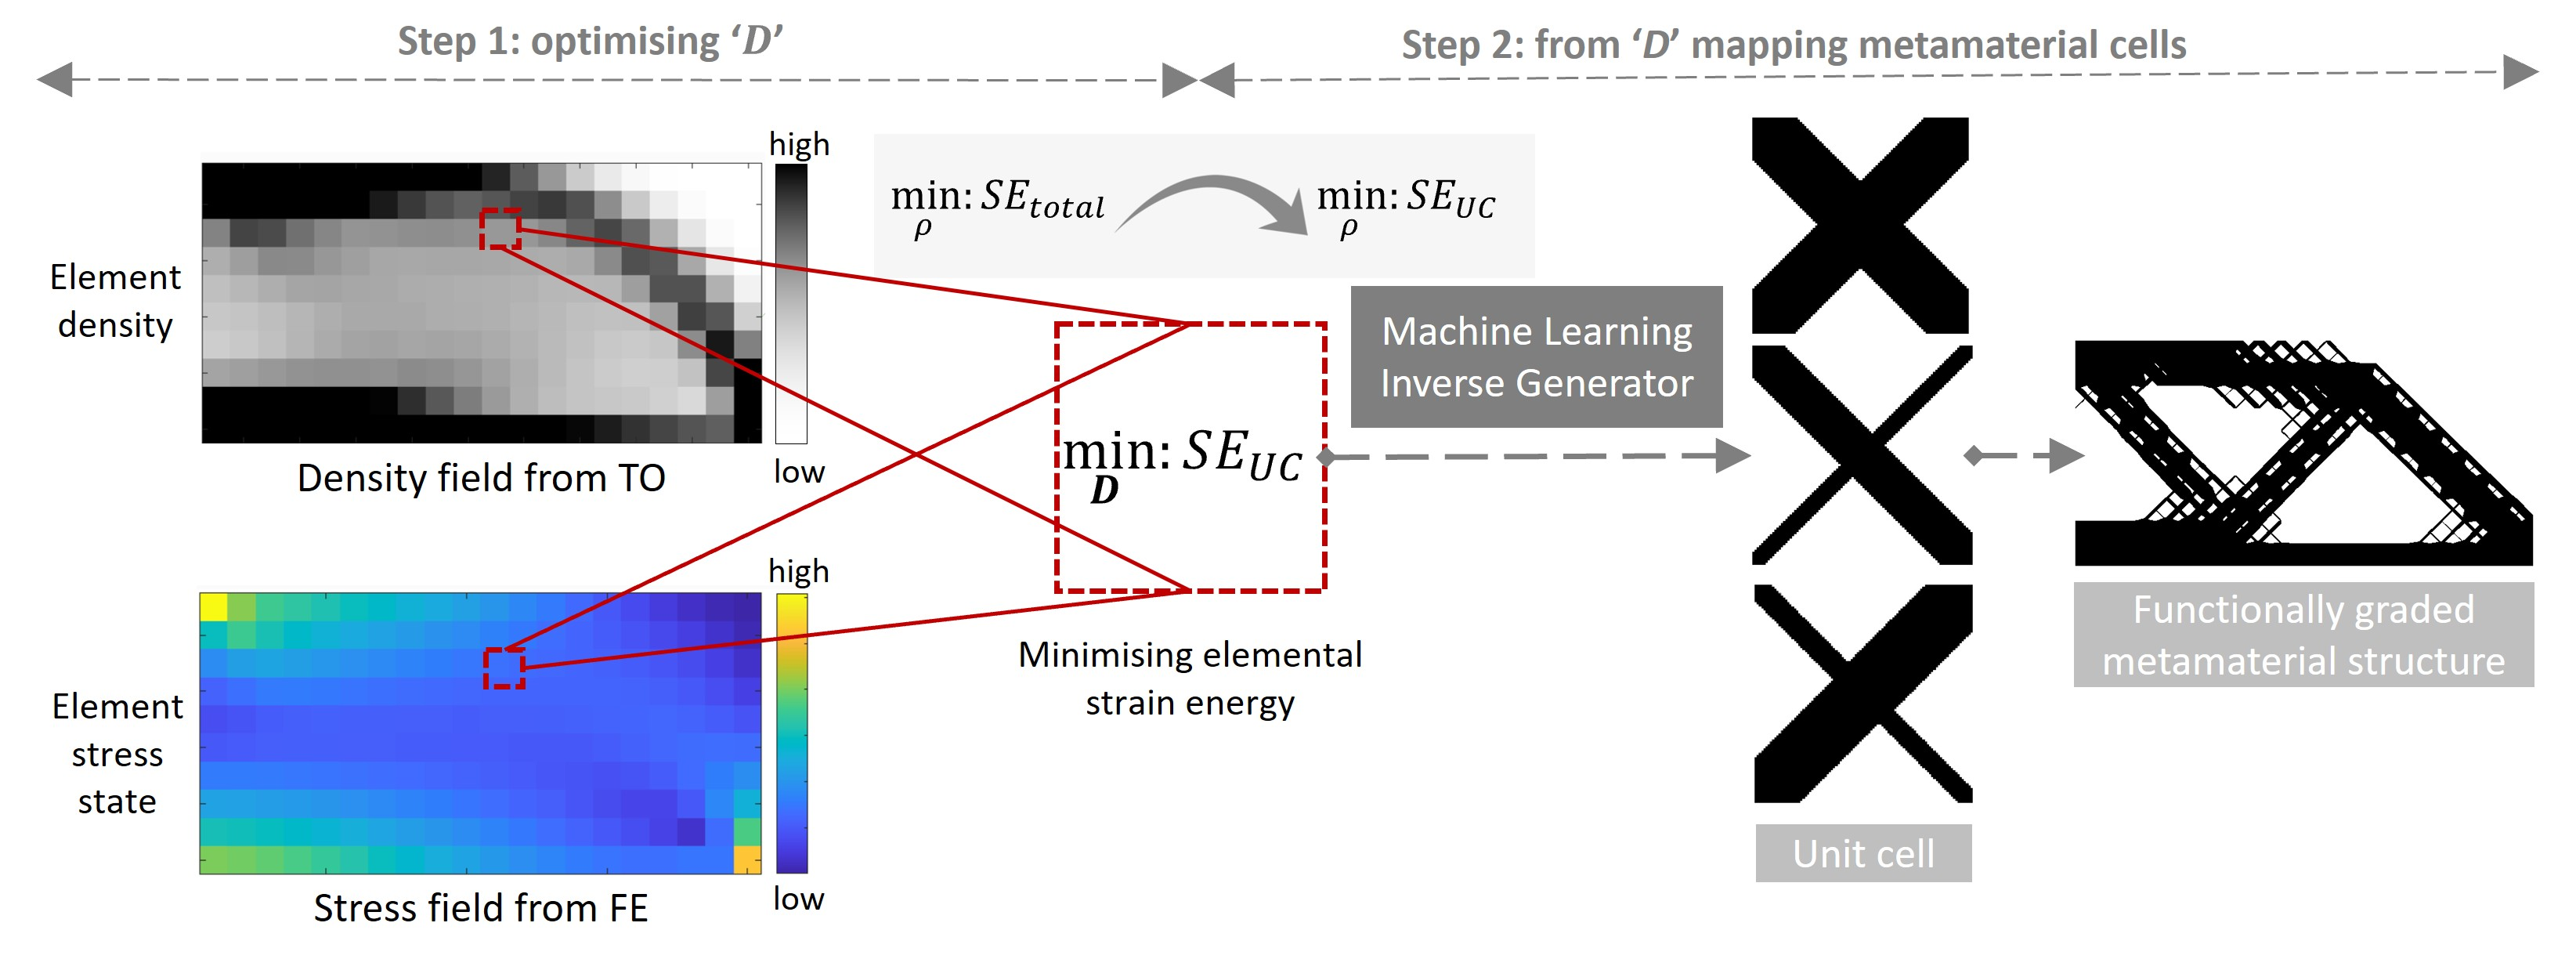

--------------

### Import library

Run the cell below to import necessarry python libraries for this tutorial.

In [ ]:
# --- Clone repository from Git
!git clone https://github.com/IDEA-lab-IC/Tutorials.git
%cd Tutorials

# --- Standard library
import time
import math
import random

# --- Core scientific stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- PyTorch
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

# --- Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Load predefined functions
from homogenise2D import generate_BCC_unitcell
from MLPpackage import *
from Multiscalepackage import *

Cloning into 'Tutorials'...


c:\Users\aw820\Documents\Tutorials\notebooks\Tutorials


Topology Optimisation code modified from: A 165 line topology optimisation code by Niels Aage and Villads Egede Johansen, January 2013 <br>
https://www.topopt.mek.dtu.dk/apps-and-software/topology-optimization-codes-written-in-python

--------------

# **1) Step 1 - from TO result derive optimal elemental property**

Run TO with a coarse mesh, and obtain the stress field of TO design.

In [ ]:
nelx = 20
nely = 10
volfrac = 0.5
rmin = 1.5
penal = 1.7
ft = 1

Minimum compliance problem with OC
ndes: 20 x 10
volfrac: 0.5, rmin: 1.5, penal: 1.7
Filter method: Density based
it.: 1 , obj.: 146.406 Vol.: 0.500, ch.: 0.200
it.: 2 , obj.: 107.419 Vol.: 0.500, ch.: 0.200
it.: 3 , obj.: 92.607 Vol.: 0.500, ch.: 0.193
it.: 4 , obj.: 86.898 Vol.: 0.500, ch.: 0.155
it.: 5 , obj.: 85.528 Vol.: 0.500, ch.: 0.079
it.: 6 , obj.: 84.831 Vol.: 0.500, ch.: 0.061
it.: 7 , obj.: 84.280 Vol.: 0.500, ch.: 0.051
it.: 8 , obj.: 83.815 Vol.: 0.500, ch.: 0.050
it.: 9 , obj.: 83.422 Vol.: 0.500, ch.: 0.050
it.: 10 , obj.: 83.099 Vol.: 0.500, ch.: 0.049
it.: 11 , obj.: 82.853 Vol.: 0.500, ch.: 0.050
it.: 12 , obj.: 82.651 Vol.: 0.500, ch.: 0.051
it.: 13 , obj.: 82.466 Vol.: 0.500, ch.: 0.048
it.: 14 , obj.: 82.297 Vol.: 0.500, ch.: 0.040
it.: 15 , obj.: 82.170 Vol.: 0.500, ch.: 0.040
it.: 16 , obj.: 81.993 Vol.: 0.500, ch.: 0.038
it.: 17 , obj.: 81.922 Vol.: 0.500, ch.: 0.034
it.: 18 , obj.: 81.857 Vol.: 0.500, ch.: 0.037
it.: 19 , obj.: 81.760 Vol.: 0.500, ch.: 0.036


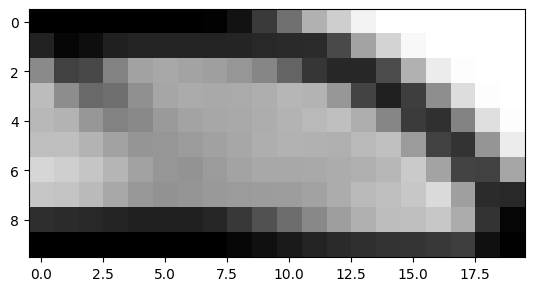

In [ ]:
state = topopt2D(
        nelx=nelx,
        nely=nely,
        volfrac=volfrac,
        penal=penal,
        rmin=rmin,
        ft=ft,
        Emax=1.0,
        Emin=1e-9,
        nu=0.3,
        max_iter=200,
        plot_density=True,
    )

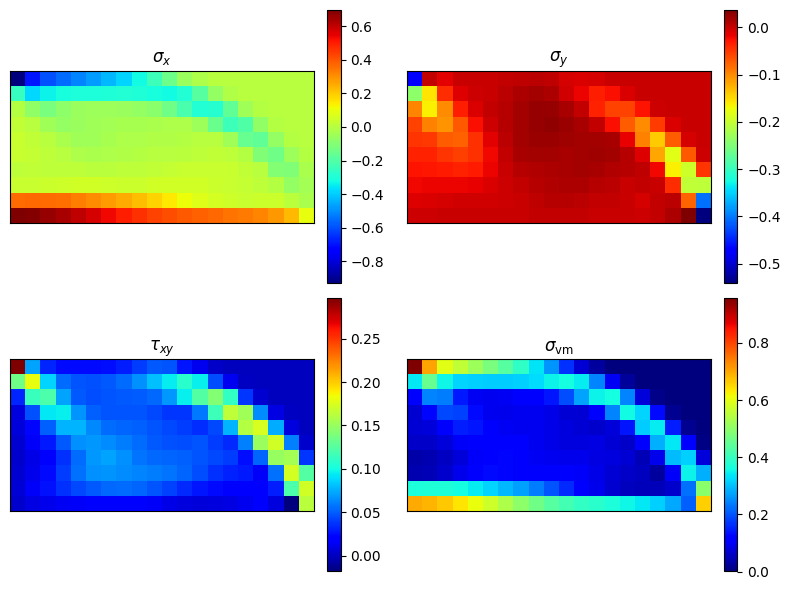

In [ ]:
stress = compute_element_stress_and_von_mises(state, sigma_yield=1.0, mask=False)
plot_stress_all(stress, cmap="jet")

Based on the obtained TO result and stress field, derive the optimal properties for each element over the design domain.

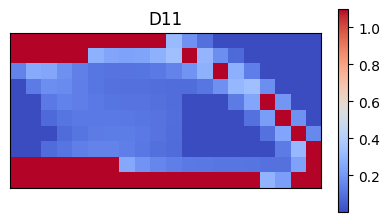

In [ ]:
# --- Load the dataset as numpy array
De = np.load("optimalDe.npy")
De = De['De']

plot_De_field(De, nelx, nely, idx=0)

# **2) Step 2 - output metamaterial cells**

<h4><font color="lightblue">MLP Inverse Generator training</font></h3>

In [ ]:
# --- Load the dataset as numpy array
data  = np.load("dataset_2D_BCC_500.npz")
prop  = data["prop"]    # input features
param = data["param"]   # target outputs

# --- Determine dimensions
N, in_dim  = prop.shape
_, out_dim = param.shape

# --- Split dataset
prop_train, prop_val, prop_test, param_train, param_val, param_test = split_prop_param(
    prop, param, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, print_summary=False)

# --- Scale dataset
prop_train, prop_val, prop_test, param_train, param_val, param_test, in_scaler, out_scaler = scale_datasets(
    prop_train, prop_val, prop_test, param_train, param_val, param_test,
    scale_inputs=True, scale_outputs=True, feature_range=(-1, 1), print_summary=False)

# --- Convert to Torch tensors
X_train, Y_train, X_val, Y_val, X_test, Y_test = map(
    lambda a: torch.from_numpy(a).float(),
    (prop_train, param_train, prop_val, param_val, prop_test, param_test))

# --- Data loader
BATCH_SIZE = 256 # number of samples per mini-batch
train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val,   Y_val),   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test,  Y_test),  batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# --- Defome model archietecture
HIDDEN = (8, )         # e.g., (), (64,), (128,64), (256,128,64), ...
DROPOUT = 0.0
model = MLP(in_dim=in_dim, hidden=HIDDEN, out_dim=out_dim, dropout=DROPOUT)

In [ ]:
# --- Train model
model, train_losses, val_losses = train_model(
    model,
    train_loader,
    val_loader,
    epochs=300, # training epoch
    patience=20, # early stopping if no validation improvement
    criterion=nn.MSELoss(), # Mean Squared Error (MSE) loss for regression
    optimizer=torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4), # Adam optimizer – efficient and commonly used
)

=== Training started ===
Epoch   1/300 | Train: 0.005431 | Val: 0.005136
Epoch  20/300 | Train: 0.003472 | Val: 0.003362
Epoch  40/300 | Train: 0.002340 | Val: 0.002323
Epoch  60/300 | Train: 0.001753 | Val: 0.001805
Epoch  80/300 | Train: 0.001438 | Val: 0.001528
Epoch 100/300 | Train: 0.001286 | Val: 0.001332
Epoch 120/300 | Train: 0.001192 | Val: 0.001286
Epoch 140/300 | Train: 0.001148 | Val: 0.001261
Epoch 160/300 | Train: 0.001138 | Val: 0.001267
Early stopping at epoch 175 (best val = 0.001221)
=== Training complete ===


#### Output cell parameters

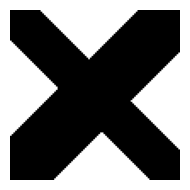

Row: 5 Column: 5
Element number: 55 out of 0-199 elements
Cell parameter r: [0.17282078 0.24212167 0.17350093 0.25751707]


In [ ]:
ix = 5
iy = 5
De_row, el = pick_De_i(De, ix, iy, nelx, nely)
r = predict_r_from_De(De_row, model=model); r1, r2, r3, r4 = map(float, r)
generate_BCC_unitcell(a=100, r1=r1, r2=r2, r3=r3, r4=r4)

print("Row:", iy, "Column:", ix)
print("Element number:", el, "out of 0-199 elements")
print("Cell parameter r:", r)

#### Postprocessing and Construct Multiscale Structure

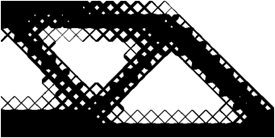